In [40]:
# import libraries
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_13656/3733693253.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create the data

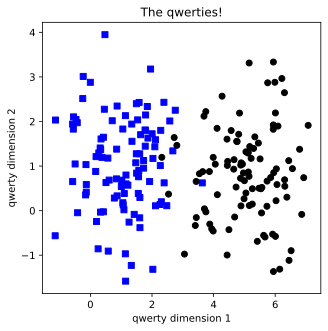

In [41]:
# Parameters
n_per_clust = 100
blur = 1
A = [1, 1]
B = [5, 1]

# Generate data
a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
# Concatanate into a matrix
data_np = np.hstack(tup=(a, b)).T

# True labels
labels_np = np.vstack(tup=(np.zeros(shape=(n_per_clust, 1)), np.ones(shape=(n_per_clust, 1))))

# Convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# Show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs')
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# Functions to build and train the model

In [42]:
def create_ANN_model(learning_rate):
  # Model architecture
  # Final activation unit (not needed b/c we use BCEWithLogitsLoss)
  ANN_classify = nn.Sequential(
    nn.Linear(in_features=2, out_features=1), # Input layer
    nn.ReLU(),                                # Activation Unit
    nn.Linear(in_features=1, out_features=1), # Output unit
  )

  # Loss function
  loss_func = nn.BCEWithLogitsLoss()

  # Optimizer
  optimizer = torch.optim.SGD(params=ANN_classify.parameters(), lr=learning_rate)

  # Model output
  return ANN_classify, loss_func, optimizer

# A function that trains the model

In [43]:
# A fixed parameter
num_epochs = 1000

def train_the_model(ANN_model, loss_func):
  # Initialize losses
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Forward pass
    y_hat = ANN_model(data)

    # Compute loss
    loss = loss_func(y_hat, labels)
    losses[epoch_i] = loss

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Final forward pass
  predictions = ANN_model(data)

  # Compute the predictions and report accuracy
  # NOTE: shouldn't it be predictions>.5?? -> Not use sigmoid
  total_acc = 100 * torch.mean(((predictions > 0) == labels).float())

  return losses, predictions, total_acc

# Test the new code by running it once

Final Accuracy: 94.0


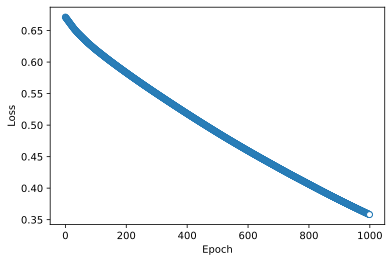

In [44]:
# Create everything
ANN_classify, loss_func, optimizer = create_ANN_model(learning_rate=.01)

# Run it
losses, predictions, total_acc = train_the_model(ANN_model=ANN_classify, loss_func=loss_func)

# Report accuracy
print(f'Final Accuracy: {total_acc}')

# Show the losses
plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Now for the experiment

In [45]:
# The set of learning rates to test
learning_rates = np.linspace(start=0.001, stop=0.01, num=40)

# Initialize results output
acc_by_LR = []
all_losses = np.zeros(shape=(len(learning_rates), num_epochs))

# Loop through learning rates
for i, learning_rate_i in enumerate(learning_rates):
  # Create and run the model
  ANN_classify, loss_func, optimizer = create_ANN_model(learning_rate=learning_rate_i)
  losses, predictions, total_acc = train_the_model(ANN_model=ANN_classify, loss_func=loss_func)

  # Store the results
  acc_by_LR.append(total_acc)
  all_losses[i, :] = losses.detach()

# Plot the results

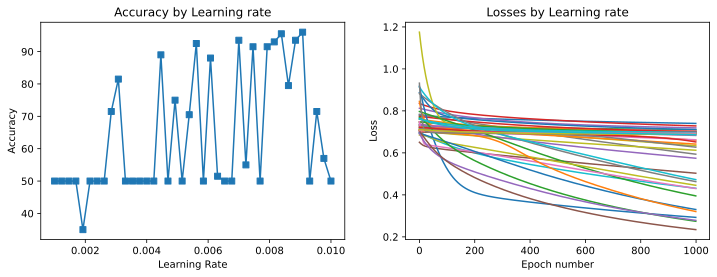

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax[0].plot(learning_rates, acc_by_LR, 's-')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by Learning rate')

ax[1].plot(all_losses.T)
ax[1].set_title('Losses by Learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

plt.show()

In [48]:
# Proportion of runs where the model had at least 70% accuracy
sum(torch.tensor(acc_by_LR) > 70) / len(acc_by_LR)

tensor(0.4000)

# Run a meta-experiment to get more reliable results

In [49]:
# Run a "meta-experiment" by repeating the experiment N times
#  (different random weight initializations each time)
# Note: this cell takes ~7 mins.

# Number of times to iterate through the experiment
num_exper = 50

# Matrix to store all results
acc_meta = np.zeros(shape=(num_exper, len(learning_rates)))

# Fewer epochs to reduce computation time
num_epochs = 500

# Now for the experiment
for exper in range(num_exper):
  for i, learning_rate_i in enumerate(learning_rates):
    # Create and run the model
    ANN_classify, loss_func, optimizer = create_ANN_model(learning_rate=learning_rate_i)
    losses, predictions, total_acc = train_the_model(ANN_model=ANN_classify, loss_func=loss_func)

    # Store the results
    acc_meta[exper, i] = total_acc

## Now plot the results, averaged over experiments

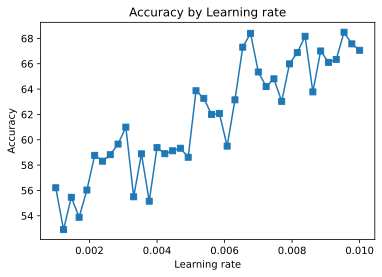

In [50]:
plt.plot(learning_rates, np.mean(acc_meta, axis=0), 's-')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by Learning rate')
plt.show()

# Additional explorations
1) The closeness of the qwerties groups is determined by the XY locations of the centroids, and by the blur parameter.
   Try increasing or decreasing the blur (e.g., to 2 or .5). How does this affect the number of times that the model
   successfully learned to categorize the two conditions?

2) The mean of a set of numbers is easily interpretable only if the data are roughly normally or uniformly distributed 
   (see lecture "Mean and variance" in Math section). Do you think the mean is a valid description of the performance
   of the model's accuracy in the meta-experiment? Use a different metric (e.g., one we discussed in this video!) and 
   plot that result on the same graph as the average. You might need to do some normalization to get them in the same 
   range. Does this alternative method lead to a different conclusion?

3) Related to the previous comment, perhaps showing an image of the performance (variable accMeta) would be more 
   appropriate. Create a heat map that shows learning rate on the x-axis, experiment repetitions on the y-axis, and
   the final accuracy in color. Label the axes and specify suitable color boundaries.